In [1]:
# necessary imports
import re
import unicodedata
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
import matplotlib.pyplot as plt
import contractions
import inflect
from wordcloud import WordCloud
from fuzzywuzzy import fuzz
import gensim

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score
from sklearn.metrics import log_loss, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from xgboost import XGBClassifier

from gensim.models import KeyedVectors
from scipy.special import expit

%matplotlib inline

In [2]:
stop_words = stopwords.words('english')

In [3]:
# setting paths to the dataset
train = 'data/train.csv'
test = 'data/test.csv'

In [4]:
train_data = pd.read_csv(train)
test_data = pd.read_csv(test)

In [5]:
train_data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [6]:
test_data.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [7]:
train_data.shape, test_data.shape

((404290, 6), (2345796, 3))

Over 400000 rows of data to work with. Let's view the number of duplicated questions.

In [8]:
is_duplicate = train_data['is_duplicate'] == 1
is_duplicate.value_counts()

False    255027
True     149263
Name: is_duplicate, dtype: int64

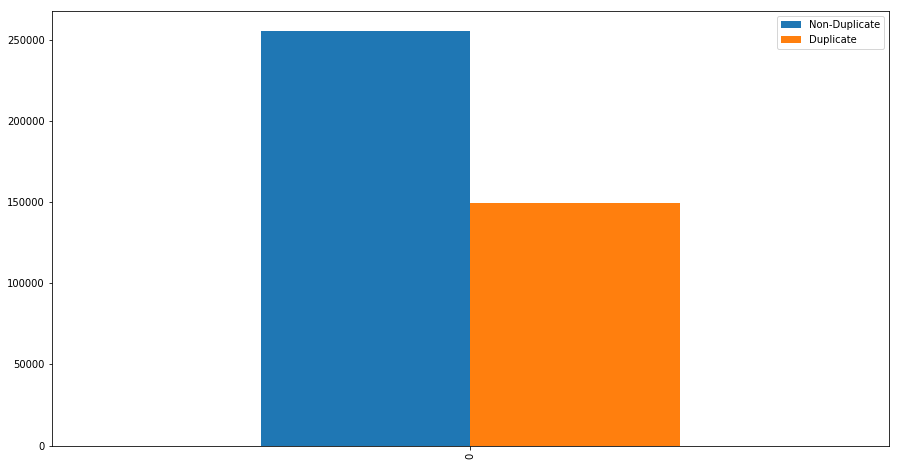

In [9]:
duplicate_df = pd.DataFrame([is_duplicate.value_counts().values[0], is_duplicate.value_counts().values[1]])
duplicate_df.index = ['Non-Duplicate', 'Duplicate']
# duplicate_df.T
duplicate_df.T.plot(kind='bar', figsize=(15,8))

In [10]:
# lets get the percentage of duplicates
percent = (is_duplicate.value_counts().values[1] / train_data.shape[0]) * 100
print(f'The percentage of duplicated question pairs is {percent}%')

The percentage of duplicated question pairs is 36.9197853026293%


**Text Preprocessing**

This the first step to solving the problem at hand. I will consider the following techniques;

*   Noise removal
*   Processing contractions
*   Tokenization
*   Normalization
*   Noise removal


The initial noise removal will be to remove beginning and trailing white spaces if it happens to be the case

In [11]:
# lets make sure none of the questions has beginning and trailing whitespaces
def remove_white_spaces(text):
  '''
  Remove beginning and trailing whitespaces from text
  '''
  return text.strip()

Contractions will also be replaced. For instance "didn't" will become "did not"

In [12]:
# let replace all contractions. for instance "didn't" to "did not"
def replace_contractions(text):
  '''
  Replace contractions in a text
  '''
  return contractions.fix(text)

Next, each question will be tokenized into token.

In [13]:
# next we tokenize each question which is to split the words that make up a question into tokens or split questions into words
def tokenize_words(text):
  '''
  Split questions into words
  '''
  return nltk.word_tokenize(text)

For the normalization stage, a  number of techniques will be used.



*   Lemmatization
*   Remove non-ascii words
*   Replace number symbols with words
*   Convert words to lowercase
*   Remove punctuations

In [14]:
# lemmatization is converting word to it's dictionary base form
def lemmatize(words):
    '''
    Convert words to base dict form
    '''
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

In [15]:
# characters that are non-ascii will be removed
def remove_non_ascii(words):
    '''
    Remove non-ascii characters from list of words
    '''
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

In [16]:
# the number `1` becomes 'one'
def replace_numbers(words):
    '''
    Replace integers in list of words from symbolic form to text form
    '''
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

In [17]:
# convert words to lowercase
def to_lowercase(words):
    '''
    Convert all characters to lowercase
    '''
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

In [18]:
# remove punctuations
def remove_punctuation(words):
    '''
    Remove punctuation from words
    '''
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

In [19]:
def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    return words

In [20]:
# finally we remove stop words
def remove_stopwords(words):
    '''
    Remove stop words from list of words
    '''
    new_words = []
    for word in words:
        if word not in stop_words:
            new_words.append(word)
    return new_words

In [21]:
# for question1 column
train_data['question1'] = train_data['question1'].apply(lambda text: remove_white_spaces(str(text)))
train_data['question1'] = train_data['question1'].apply(lambda text: replace_contractions(str(text)))
train_data['question1'] = train_data['question1'].apply(lambda text: tokenize_words(text))
train_data['question1'] = train_data['question1'].apply(lambda words: normalize(words))
train_data['question1'] = train_data['question1'].apply(lambda words: lemmatize(words))
train_data['question1'] = train_data['question1'].apply(lambda words: remove_stopwords(words))

# for question2 column
train_data['question2'] = train_data['question2'].apply(lambda text: remove_white_spaces(str(text)))
train_data['question2'] = train_data['question2'].apply(lambda text: replace_contractions(str(text)))
train_data['question2'] = train_data['question2'].apply(lambda text: tokenize_words(text))
train_data['question2'] = train_data['question2'].apply(lambda words: normalize(words))
train_data['question2'] = train_data['question2'].apply(lambda words: lemmatize(words))
train_data['question2'] = train_data['question2'].apply(lambda words: remove_stopwords(words))

In [22]:
train_data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,"[step, step, guide, invest, share, market, india]","[step, step, guide, invest, share, market]",0
1,1,3,4,"[story, kohinoor, kohinoor, diamond]","[would, happen, indian, government, steal, koh...",0
2,2,5,6,"[increase, speed, internet, connection, use, vpn]","[internet, speed, increase, hack, dns]",0
3,3,7,8,"[mentally, lonely, solve]","[find, remainder, math, twenty-three, twenty-f...",0
4,4,9,10,"[one, dissolve, water, quikly, sugar, salt, me...","[fish, would, survive, salt, water]",0


In [23]:
unwanted_columns = ['id', 'qid1', 'qid2']
data = train_data.drop(unwanted_columns, axis=1)

In [24]:
data.head()

,question1,question2,is_duplicate
0,"[step, step, guide, invest, share, market, india]","[step, step, guide, invest, share, market]",0
1,"[story, kohinoor, kohinoor, diamond]","[would, happen, indian, government, steal, koh...",0
2,"[increase, speed, internet, connection, use, vpn]","[internet, speed, increase, hack, dns]",0
3,"[mentally, lonely, solve]","[find, remainder, math, twenty-three, twenty-f...",0
4,"[one, dissolve, water, quikly, sugar, salt, me...","[fish, would, survive, salt, water]",0


**Featuere Extraction/Engineering**

Here, a number of features will be created from the preprocessed texts.

Metadata

*   length of each question
*   differences in  length
*   common words in each pair of question
*   length of characters in each question
*   length of words in each question

*   string similarity
*   partial string similarity



In [25]:
# text metadata
data['len_q1'] = data['question1'].apply(lambda words: len(words))
data['len_q2'] = data['question2'].apply(lambda words: len(words))
data['diff_len'] = data.len_q1 - data.len_q2
data['common_words'] = data.apply(lambda words: len(set(words['question1']).intersection(set(words['question2']))), axis=1)
data['len_char_q1'] = data['question1'].apply(lambda words: len(set(''.join(words))))
data['len_char_q2'] = data['question2'].apply(lambda words: len(set(''.join(words))))

# fuzzywuzzy
data['ratio'] = data.apply(lambda x: fuzz.ratio(' '.join(x['question1']), ' '.join(x['question2'])), axis=1)
data['partial_ratio'] = data.apply(lambda x: fuzz.partial_ratio(' '.join(x['question1']), ' '.join(x['question2'])), axis=1)
data['token_sort_ratio'] = data.apply(lambda x: fuzz.token_sort_ratio(' '.join(x['question1']), ' '.join(x['question2'])), axis=1)
data['token_set_ratio'] = data.apply(lambda x: fuzz.token_set_ratio(' '.join(x['question1']), ' '.join(x['question2'])), axis=1)
data['qratio'] = data.apply(lambda x: fuzz.QRatio(' '.join(x['question1']), ' '.join(x['question2'])), axis=1)
data['wratio'] = data.apply(lambda x: fuzz.WRatio(' '.join(x['question1']), ' '.join(x['question2'])), axis=1)
data['partial_token_sort_ratio'] = data.apply(lambda x: fuzz.partial_token_set_ratio(' '.join(x['question1']), ' '.join(x['question2'])), axis=1)
data['partial_token_set_ratio'] = data.apply(lambda x: fuzz.partial_token_set_ratio(' '.join(x['question1']), ' '.join(x['question2'])), axis=1)

In [26]:
data.head()

,question1,question2,is_duplicate,len_q1,len_q2,diff_len,common_words,len_char_q1,len_char_q2,ratio,partial_ratio,token_sort_ratio,token_set_ratio,qratio,wratio,partial_token_sort_ratio,partial_token_set_ratio
0,"[step, step, guide, invest, share, market, india]","[step, step, guide, invest, share, market]",0,7,6,1,5,15,15,92,100,92,100,92,95,100,100
1,"[story, kohinoor, kohinoor, diamond]","[would, happen, indian, government, steal, koh...",0,4,9,-5,2,12,20,57,90,59,84,57,86,100,100
2,"[increase, speed, internet, connection, use, vpn]","[internet, speed, increase, hack, dns]",0,6,5,1,3,13,12,51,56,70,84,51,80,100,100
3,"[mentally, lonely, solve]","[find, remainder, math, twenty-three, twenty-f...",0,3,8,-5,0,10,19,20,38,20,27,20,41,43,43
4,"[one, dissolve, water, quikly, sugar, salt, me...","[fish, would, survive, salt, water]",0,10,5,5,2,22,14,43,52,40,51,43,86,100,100


Text(0,0.5,'Probability')

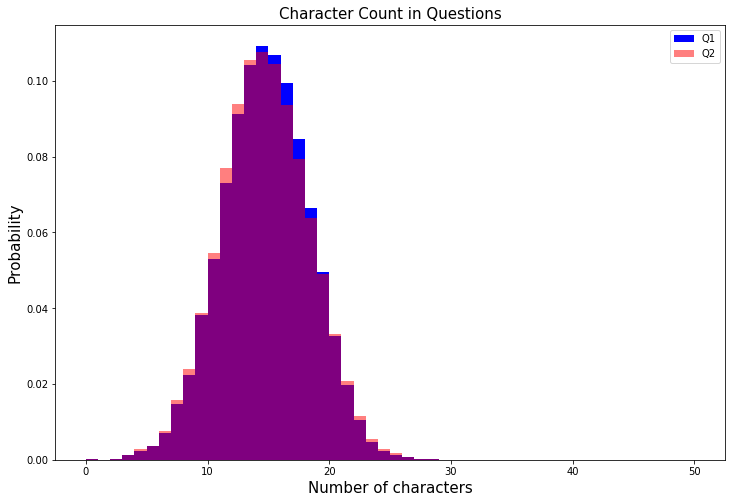

In [4]:
#visual on character count
plt.figure(figsize=(12, 8))
plt.hist(data['len_char_q1'], bins=50, range=[0, 50], color='blue', density=True, label='Q1')
plt.hist(data['len_char_q2'], bins=50, range=[0, 50], color='red', alpha = 0.5, density=True, label='Q2')
plt.title('Character Count in Questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

Most question have characters between 10 and 20, maybe about 15 characters.

Text(0,0.5,'Probability')

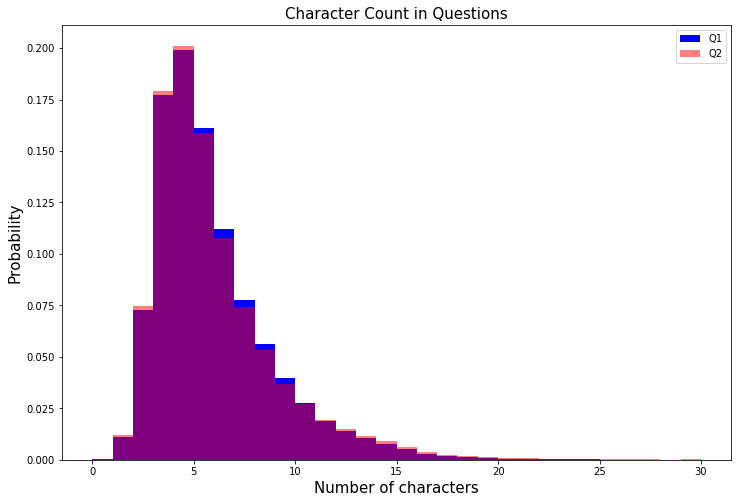

In [7]:
#visual on word count
plt.figure(figsize=(12, 8))
plt.hist(data['len_q1'], bins=30, range=[0, 30], color='blue', density=True, label='Q1')
plt.hist(data['len_q2'], bins=30, range=[0, 30], color='red', alpha = 0.5, density=True, label='Q2')
plt.title('Character Count in Questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

Most questions have 5 words, that's if stopwords are removed

Text(0.5,0,'Number of Common Words')

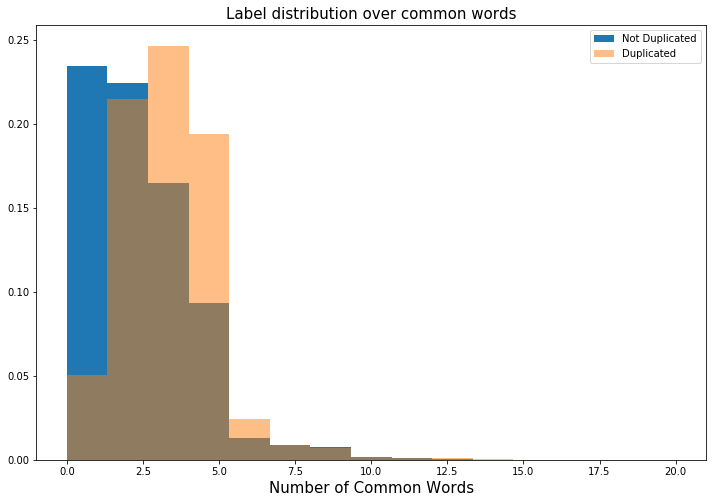

In [12]:
#visual on common words
plt.figure(figsize=(12, 8))
common_words = data['common_words']
plt.hist(common_words[data['is_duplicate'] == 0], bins=15, range=[0, 20], density=True, label='Not Duplicated')
plt.hist(common_words[data['is_duplicate'] == 1], bins=15, range=[0, 20], density=True, alpha=0.5, label='Duplicated')
plt.legend()
plt.title('Label distribution over common words', fontsize=15)
plt.xlabel('Number of Common Words', fontsize=15)

As expected duplicated question have a higher number of common words.

Text(0.5,0,'Partial token set ratio')

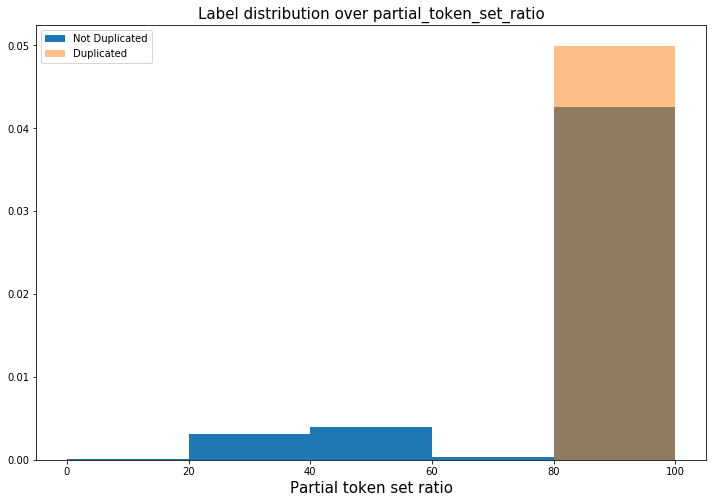

In [16]:
#visual on common words
plt.figure(figsize=(12, 8))
partial_token_set_ratio = data['partial_token_set_ratio']
plt.hist(partial_token_set_ratio[data['is_duplicate'] == 0], bins=5, density=True, label='Not Duplicated')
plt.hist(partial_token_set_ratio[data['is_duplicate'] == 1], bins=5, density=True, alpha=0.5, label='Duplicated')
plt.legend()
plt.title('Label distribution over partial_token_set_ratio', fontsize=15)
plt.xlabel('Partial token set ratio', fontsize=15)

As expected a higher number of duplicated question have a high partial_token_set ratio.

With the new featuers lets can check how wrong the human generated labels are with respect to:

* Difference in question length
* Partial ratio
* Token set ratio

More imformation on the fuzzywuzzy features can be found [here](http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/)

In [28]:
data[data['diff_len'] <= 5]['is_duplicate'].value_counts()

0    242672
1    147990
Name: is_duplicate, dtype: int64

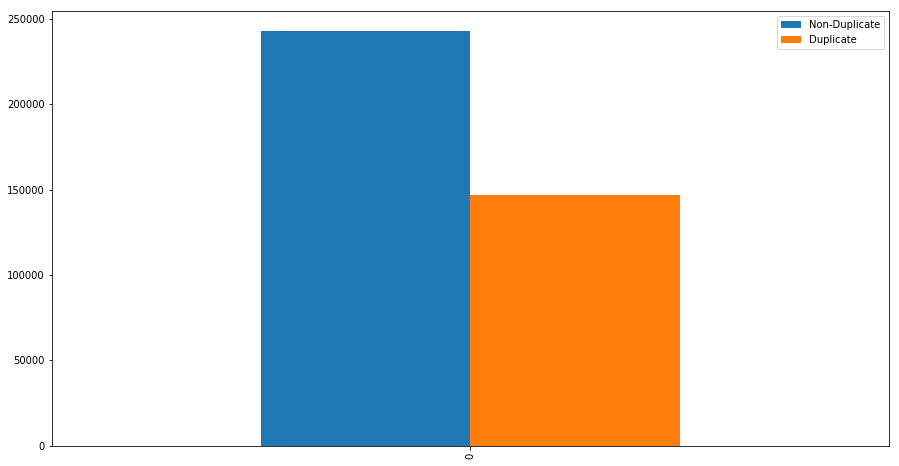

In [29]:
# assuming duplicated questions have a difference in length less than 5
duplicate_df = pd.DataFrame([data[data['diff_len'] <= 5]['is_duplicate'].value_counts().values[0], data[data['diff_len'] < 5]['is_duplicate'].value_counts().values[1]])
duplicate_df.index = ['Non-Duplicate', 'Duplicate']
# duplicate_df.T
duplicate_df.T.plot(kind='bar', figsize=(15,8))

In [30]:
print(data[data['diff_len'] <= 5]['is_duplicate'].value_counts().values[0], data[data['diff_len'] < 5]['is_duplicate'].value_counts().values[1])
print(is_duplicate.value_counts().values[0], is_duplicate.value_counts().values[1])

242672 146801
255027 149263


In [31]:
data.describe()

,is_duplicate,len_q1,len_q2,diff_len,common_words,len_char_q1,len_char_q2,ratio,partial_ratio,token_sort_ratio,token_set_ratio,qratio,wratio,partial_token_sort_ratio,partial_token_set_ratio
count,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000,404290.000000
mean,0.369198,5.454790,5.522565,-0.067776,2.596186,14.311094,14.247703,62.446160,70.221514,64.671716,75.962557,62.454424,77.569626,94.523674,94.523674
std,0.482588,2.948506,3.247303,3.077137,1.679733,3.591929,3.661004,20.495043,20.037914,19.814359,21.253734,20.488127,17.873450,17.214385,17.214385
min,0.000000,0.000000,0.000000,-90.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,3.000000,3.000000,-1.000000,2.000000,12.000000,12.000000,46.000000,54.000000,50.000000,62.000000,46.000000,68.000000,100.000000,100.000000
50%,0.000000,5.000000,5.000000,0.000000,2.000000,14.000000,14.000000,62.000000,70.000000,65.000000,80.000000,62.000000,86.000000,100.000000,100.000000
75%,1.000000,7.000000,7.000000,1.000000,3.000000,17.000000,17.000000,79.000000,86.000000,80.000000,96.000000,79.000000,89.000000,100.000000,100.000000
max,1.000000,53.000000,99.000000,44.000000,24.000000,35.000000,34.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


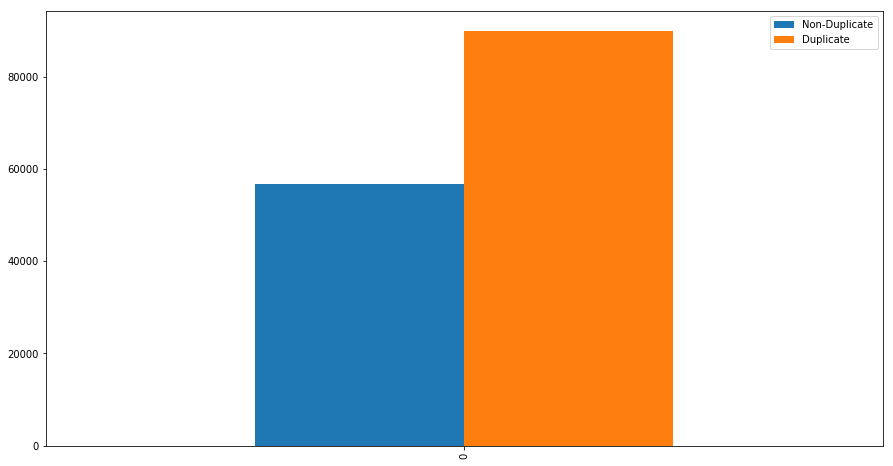

In [32]:
# assuming duplicated questions have a partial ratio from 75th percentile onwards
duplicate_df = pd.DataFrame([data[data['partial_ratio'] > 85]['is_duplicate'].value_counts().values[0], data[data['partial_ratio'] < 85]['is_duplicate'].value_counts().values[1]])
duplicate_df.index = ['Non-Duplicate', 'Duplicate']
# duplicate_df.T
duplicate_df.T.plot(kind='bar', figsize=(15,8))

Over 80000 data points rightly labelled according the partial ratio feature.

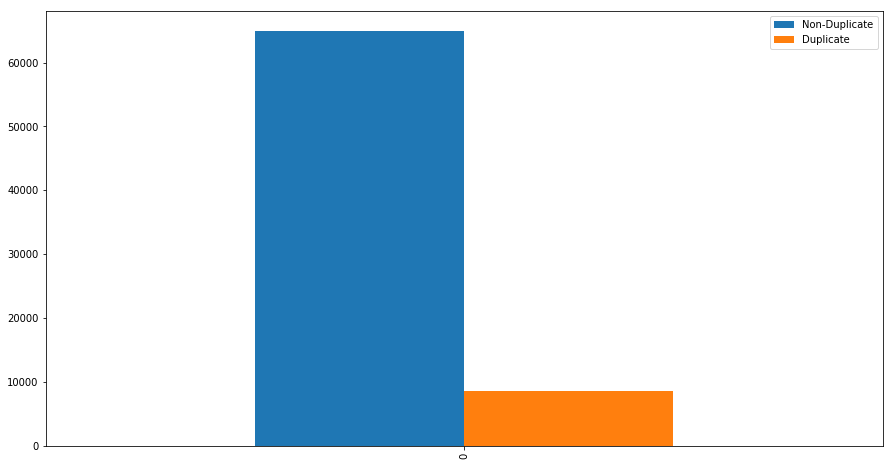

In [33]:
# assuming duplicated questions have a partial ratio in above 75th percentile
duplicate_df = pd.DataFrame([data[data['token_set_ratio'] > 92]['is_duplicate'].value_counts().values[0], data[data['partial_ratio'] < 92]['token_set_ratio'].value_counts().values[1]])
duplicate_df.index = ['Non-Duplicate', 'Duplicate']
# duplicate_df.T
duplicate_df.T.plot(kind='bar', figsize=(15,8))

More than 10000 data points wrongly labelled according the the token set ratio.

**Benchmark Model**

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.30, random_state=42)

scoring = make_scorer(log_loss, needs_proba=True, greater_is_better=False)

pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()), ('LR', LogisticRegression())])))
pipelines.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()), ('RF', RandomForestClassifier())])))
pipelines.append(('ScaledXG', Pipeline([('Scaler', StandardScaler()), ('XG', XGBClassifier())])))

results = []
names = []

for name, model in pipelines:
    kfold = KFold(n_splits=10, random_state=42)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: -0.539474 (0.002733)
ScaledRF: -0.983306 (0.023646)
ScaledXG: -0.500558 (0.002251)


**WORD2VEC FEATURE EXTRACTION**



In [34]:
word2vec_file = 'glove.6B.300d.txt.word2vec'

In [35]:
model = KeyedVectors.load_word2vec_format(word2vec_file, binary=False)

In [36]:
def word_similarity(x1, x2):
    '''
    Check each word in a question pair against each other for similarity and squash it between 0 and 1.
    Hence, very similar questions have a scopre closer to one and vice versa.
    '''
    similarity = []
    for word1 in x1:
        for word2 in x2:
            try:
                similarity.append(model.similarity(word1, word2))
            except KeyError as e:
                continue
    return expit(sum(similarity))

In [37]:
data['word_similarity'] = data.apply(lambda x: word_similarity(x['question1'], x['question2']), axis=1)

In [10]:
# data = pd.read_csv('readydata.csv', index_col=0)
# X.head()

In [7]:
unwanted_columns = ['question1', 'question2']

training_data = data.drop(unwanted_columns, axis=1)
X = training_data.drop(['is_duplicate'], axis=1)
Y = training_data['is_duplicate']

**Machine Learning Models with Word2Vec Feattures**

In [38]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.30, random_state=42)

In [44]:
scoring = make_scorer(log_loss, needs_proba=True, greater_is_better=False)

In [46]:
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()), ('LR', LogisticRegression())])))
pipelines.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()), ('RF', RandomForestClassifier())])))
pipelines.append(('ScaledXG', Pipeline([('Scaler', StandardScaler()), ('XG', XGBClassifier())])))

results = []
names = []

for name, model in pipelines:
    kfold = KFold(n_splits=10, random_state=42)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: -0.532948 (0.002666)
ScaledRF: -0.978139 (0.031121)
ScaledXG: -0.491490 (0.002421)


The XGBClassifier was the better model here so it can further be tuned to get a better log loss score. RandomForestClassifier performed poorly because it does not work well with sparse datasets. The benchmark model is to get a log loss score below `0.4`.

In [47]:
# xgboostclassifier
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)

kfold = KFold(n_splits=10, random_state=42)

max_depth = [3, 4, 5, 6, 7, 8]
min_child_weight = [1, 2, 3, 4]
param_grid = dict(max_depth=max_depth, min_child_weight=min_child_weight)

model = XGBClassifier()

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(scaled_X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.467980 using {'max_depth': 8, 'min_child_weight': 1}
-0.491531 (0.002413) with: {'max_depth': 3, 'min_child_weight': 1}
-0.491382 (0.002507) with: {'max_depth': 3, 'min_child_weight': 2}
-0.491456 (0.002597) with: {'max_depth': 3, 'min_child_weight': 3}
-0.491640 (0.002299) with: {'max_depth': 3, 'min_child_weight': 4}
-0.483421 (0.002538) with: {'max_depth': 4, 'min_child_weight': 1}
-0.483353 (0.002552) with: {'max_depth': 4, 'min_child_weight': 2}
-0.483352 (0.002591) with: {'max_depth': 4, 'min_child_weight': 3}
-0.483276 (0.002412) with: {'max_depth': 4, 'min_child_weight': 4}
-0.477563 (0.002503) with: {'max_depth': 5, 'min_child_weight': 1}
-0.477616 (0.002649) with: {'max_depth': 5, 'min_child_weight': 2}
-0.477764 (0.002562) with: {'max_depth': 5, 'min_child_weight': 3}
-0.477633 (0.002638) with: {'max_depth': 5, 'min_child_weight': 4}
-0.473465 (0.002548) with: {'max_depth': 6, 'min_child_weight': 1}
-0.473475 (0.002732) with: {'max_depth': 6, 'min_child_weight': 2}


The log loss score has improved. Maybe it can be further be improved with a better larger `max_depth` argument but I would make due with what I got and improve it later.

Lets add more features to see if the model improves. Next will be to generate the tf-idf vectorizer for the dataset.

In [46]:
# join question1 and question2 columns to one axis
train_data_q1, train_data_q2 = data[['question1']], data[['question2']]
print(f'Length of Question 1: {len(train_data_q1)}, \nLength of Question 2: {len(train_data_q2)} \nTotal: {len(train_data_q1)+len(train_data_q2)}')
train_data_q1.columns, train_data_q2.columns = ['question'], ['question'] 
train_q = pd.concat([train_data_q1, train_data_q2], ignore_index=True, axis=0)

Length of Question 1: 404290, 
Length of Question 2: 404290 
Total: 808580


In [47]:
train_q.head()

,question
0,"[step, step, guide, invest, share, market, india]"
1,"[story, kohinoor, kohinoor, diamond]"
2,"[increase, speed, internet, connection, use, vpn]"
3,"[mentally, lonely, solve]"
4,"[one, dissolve, water, quikly, sugar, salt, me..."


In [48]:
# prepare question values for tfidfvectorizer
docs = []
for q in train_q.values:
    docs.append(*q)
docs

[['step', 'step', 'guide', 'invest', 'share', 'market', 'india'],
 ['story', 'kohinoor', 'kohinoor', 'diamond'],
 ['increase', 'speed', 'internet', 'connection', 'use', 'vpn'],
 ['mentally', 'lonely', 'solve'],
 ['one',
  'dissolve',
  'water',
  'quikly',
  'sugar',
  'salt',
  'methane',
  'carbon',
  'di',
  'oxide'],
 ['astrology', 'capricorn', 'sun', 'cap', 'moon', 'cap', 'rise', 'say'],
 ['buy', 'tiago'],
 ['good', 'geologist'],
 ['use', 'instead'],
 ['motorola', 'company', 'hack', 'charter', 'motorolla', 'dcx3400'],
 ['method', 'find', 'separation', 'slit', 'use', 'fresnel', 'biprism'],
 ['read', 'find', 'youtube', 'comment'],
 ['make', 'physics', 'easy', 'learn'],
 ['first', 'sexual', 'experience', 'like'],
 ['laws',
  'change',
  'status',
  'student',
  'visa',
  'green',
  'card',
  'us',
  'compare',
  'immigration',
  'laws',
  'canada'],
 ['would',
  'trump',
  'presidency',
  'mean',
  'current',
  'international',
  'master',
  'students',
  'f1',
  'visa'],
 ['manipula

**TERM FREQUENCY - INVERSE DOCUMENT FREQUENCY (TF-IDF) FEATURE EXTRACTION**

In [49]:
def dummy_fun(doc):
    return doc

tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None)

tfidfv = tfidf.fit(docs)

In [50]:
tfidfv.vocabulary_

{'step': 80297,
 'guide': 36617,
 'invest': 43102,
 'share': 76316,
 'market': 51332,
 'india': 41667,
 'story': 80555,
 'kohinoor': 46660,
 'diamond': 24270,
 'increase': 41568,
 'speed': 79367,
 'internet': 42818,
 'connection': 19737,
 'use': 89289,
 'vpn': 91099,
 'mentally': 52620,
 'lonely': 49394,
 'solve': 78803,
 'one': 60285,
 'dissolve': 25068,
 'water': 91623,
 'quikly': 69054,
 'sugar': 81311,
 'salt': 73604,
 'methane': 52881,
 'carbon': 15468,
 'di': 24211,
 'oxide': 62221,
 'astrology': 8896,
 'capricorn': 15404,
 'sun': 81455,
 'cap': 15330,
 'moon': 54641,
 'rise': 72129,
 'say': 74154,
 'buy': 14625,
 'tiago': 84765,
 'good': 35677,
 'geologist': 34771,
 'instead': 42505,
 'motorola': 54915,
 'company': 19215,
 'hack': 36993,
 'charter': 16848,
 'motorolla': 54916,
 'dcx3400': 22700,
 'method': 52890,
 'find': 31560,
 'separation': 75570,
 'slit': 78123,
 'fresnel': 33401,
 'biprism': 12363,
 'read': 69989,
 'youtube': 94776,
 'comment': 19062,
 'make': 50684,
 'phys

In [51]:
vectors = tfidfv.transform(docs)

#Use Truncated SVD for dimension reduction on the TFIDF matrix
trunc = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=10, random_state=0)
trunc_vec = trunc.fit_transform(vectors)
tfidf_vec = pd.DataFrame(trunc_vec)

#Save processed tfidf vectors for later use
tfidf_vec.to_pickle('tfidf_vec.pkl')

In [52]:
# tfidf_vec = pd.DataFrame([vectors])
tfidf_vec

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,4.795234e-02,-1.312153e-04,3.530412e-02,-2.497797e-02,-9.397993e-03,-6.473908e-02,-7.484984e-02,6.203002e-02,9.531505e-04,4.946716e-02,-3.394021e-02,-2.533678e-02,1.250192e-01,4.494577e-02,-6.345691e-02,-2.492478e-02,1.335216e-02,1.527048e-03,-1.004091e-02,-5.678747e-03
1,2.056876e-03,2.765285e-04,6.112712e-04,-1.706516e-03,-6.871059e-04,-4.827701e-04,1.261362e-03,1.990237e-04,-2.207743e-04,-2.196552e-04,1.042180e-03,-6.932942e-04,1.346773e-03,-2.401697e-03,4.936892e-04,-5.818060e-05,1.413424e-03,-2.192207e-03,9.239589e-05,-1.112117e-03
2,2.672423e-02,2.165679e-02,1.546610e-02,-9.388622e-03,-2.077619e-03,1.245896e-02,-7.192285e-03,6.166709e-03,-8.844477e-03,-9.254247e-03,1.397456e-02,1.166036e-02,2.268151e-02,-3.378619e-04,2.122262e-02,1.470029e-01,1.239918e-01,6.930907e-02,5.758877e-02,-2.289505e-03
3,3.363047e-03,3.522134e-03,2.295992e-03,-2.782724e-03,-2.333752e-03,-5.699272e-04,-4.940951e-04,2.020662e-03,-2.015868e-03,1.749330e-03,2.827649e-03,1.503789e-04,-1.929344e-03,1.687138e-04,1.641870e-03,2.939365e-03,-5.029905e-04,-3.338926e-03,-1.454758e-03,-1.917011e-03
4,1.231111e-02,1.054721e-02,1.319447e-02,-1.607256e-02,-9.220807e-03,6.030883e-03,6.984106e-03,3.317635e-03,6.377529e-03,-4.185204e-04,1.122905e-02,1.750001e-02,2.736160e-02,-1.920184e-02,1.155137e-02,6.487962e-02,-3.255995e-02,-3.871812e-02,-2.802510e-02,-5.148660e-02
5,5.331701e-03,4.802076e-03,5.062129e-03,-9.132919e-03,-7.317726e-03,3.528598e-04,3.255498e-03,-1.897685e-03,-3.344707e-03,-3.550031e-03,3.381441e-03,-1.583232e-03,6.333854e-04,-3.468789e-03,-1.038179e-03,1.959884e-03,8.096298e-03,-8.636017e-03,-5.380130e-03,6.510689e-03
6,1.608390e-02,-3.565289e-03,1.004438e-03,-2.436595e-03,6.102959e-04,-1.131551e-02,-8.072662e-04,2.151245e-03,-3.752863e-03,-6.299618e-04,-2.353934e-03,-2.420408e-03,1.243067e-02,-2.404865e-03,8.213932e-03,1.637450e-02,6.487540e-03,9.402841e-03,-1.914773e-03,-5.640833e-03
7,2.350058e-02,1.251825e-02,2.519986e-02,-3.071638e-02,-7.807276e-03,3.127315e-02,-2.913502e-02,-1.534912e-02,9.380099e-03,1.904439e-02,3.694118e-02,1.769601e-02,9.224443e-02,-5.171746e-03,2.254309e-01,-1.313595e-01,7.115950e-02,4.658006e-02,-3.132164e-02,-4.957276e-02
8,3.483024e-02,4.895116e-02,1.251688e-02,-1.479100e-02,-1.423372e-02,2.267812e-02,-1.630134e-02,1.280327e-02,-1.822801e-02,-2.573614e-02,1.218080e-02,1.271713e-02,4.040795e-02,6.665080e-03,4.275100e-02,2.855604e-01,2.539483e-01,1.362013e-01,1.455921e-01,-3.513758e-03
9,1.541873e-02,-9.051744e-06,3.903639e-03,-1.091665e-02,1.099500e-03,6.498208e-03,-4.176540e-03,2.985604e-03,-4.750016e-03,3.980407e-03,-8.761617e-03,4.110397e-03,1.036013e-02,-8.585670e-04,-5.100937e-03,1.285591e-02,2.026237e-02,1.621635e-02,-6.066100e-04,-1.275499e-02


In [53]:
#Add these TFIDF reduced vector "distance" as new features
label = data['is_duplicate']
vector_train_q1 = tfidf_vec[0:len(train_data_q1)].reset_index(drop=True)
vector_train_q2 = tfidf_vec[len(train_data_q1):].reset_index(drop=True)

In [54]:
tfidf_train_vector = np.abs(vector_train_q1.values-vector_train_q2.values)
tfidf_train_vector = pd.DataFrame(tfidf_train_vector)
tfidf_train_vector.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.025919,0.000975,0.024547,0.021847,0.007889,0.067343,0.061828,0.052749,0.002142,0.045008,0.028250,0.028973,0.114061,0.045224,0.069722,0.027543,0.009495,0.002322,0.004926,0.005390
1,0.021347,0.018373,0.034125,0.040477,0.025994,0.031584,0.031441,0.015588,0.007975,0.013343,0.008211,0.025000,0.018133,0.024310,0.016235,0.042185,0.017741,0.018431,0.005900,0.013279
2,0.005020,0.016137,0.005822,0.000820,0.003674,0.005070,0.002481,0.002206,0.005169,0.001036,0.011758,0.001187,0.019373,0.008171,0.030439,0.116210,0.093793,0.049435,0.070194,0.016946
3,0.008766,0.007857,0.001194,0.008401,0.005052,0.007107,0.006554,0.001520,0.001534,0.007324,0.004064,0.004788,0.015462,0.007252,0.004555,0.003433,0.016323,0.006684,0.003279,0.020070
4,0.006630,0.006135,0.012772,0.020391,0.024839,0.021673,0.019216,0.022836,0.004950,0.026001,0.005556,0.007067,0.024560,0.000925,0.001602,0.007026,0.014427,0.025745,0.012972,0.031018


In [55]:
new_data = pd.concat([data, tfidf_train_vector], axis=1)
new_data.head()

,question1,question2,is_duplicate,len_q1,len_q2,diff_len,common_words,len_char_q1,len_char_q2,ratio,...,10,11,12,13,14,15,16,17,18,19
0,"[step, step, guide, invest, share, market, india]","[step, step, guide, invest, share, market]",0,7,6,1,5,15,15,92,...,0.028250,0.028973,0.114061,0.045224,0.069722,0.027543,0.009495,0.002322,0.004926,0.005390
1,"[story, kohinoor, kohinoor, diamond]","[would, happen, indian, government, steal, koh...",0,4,9,-5,2,12,20,57,...,0.008211,0.025000,0.018133,0.024310,0.016235,0.042185,0.017741,0.018431,0.005900,0.013279
2,"[increase, speed, internet, connection, use, vpn]","[internet, speed, increase, hack, dns]",0,6,5,1,3,13,12,51,...,0.011758,0.001187,0.019373,0.008171,0.030439,0.116210,0.093793,0.049435,0.070194,0.016946
3,"[mentally, lonely, solve]","[find, remainder, math, twenty-three, twenty-f...",0,3,8,-5,0,10,19,20,...,0.004064,0.004788,0.015462,0.007252,0.004555,0.003433,0.016323,0.006684,0.003279,0.020070
4,"[one, dissolve, water, quikly, sugar, salt, me...","[fish, would, survive, salt, water]",0,10,5,5,2,22,14,43,...,0.005556,0.007067,0.024560,0.000925,0.001602,0.007026,0.014427,0.025745,0.012972,0.031018


In [56]:
# new_data.to_csv('finaldata.csv')

In [57]:
unwanted_columns = ['question1', 'question2']

tfidf_training_data = new_data.drop(unwanted_columns, axis=1)
X = tfidf_training_data.drop(['is_duplicate'], axis=1)
Y = tfidf_training_data['is_duplicate']

In [59]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.30, random_state=42)

In [60]:
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()), ('LR', LogisticRegression())])))
pipelines.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()), ('RF', RandomForestClassifier())])))
pipelines.append(('ScaledXG', Pipeline([('Scaler', StandardScaler()), ('XG', XGBClassifier())])))

results = []
names = []

for name, model in pipelines:
    kfold = KFold(n_splits=10, random_state=42)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: -0.520244 (0.002672)
ScaledRF: -0.782523 (0.017344)
ScaledXG: -0.480573 (0.002681)


Over here with our new features all three model improve. Yet again the XGBClassifier performed better than all the others hence we can further tune is with same hyperparameters as before.

In [62]:
# xgboostclassifier
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)

kfold = KFold(n_splits=10, random_state=42)

max_depth = [3, 4, 5, 6, 7, 8]
min_child_weight = [1, 2, 3, 4]
param_grid = dict(max_depth=max_depth, min_child_weight=min_child_weight)

model = XGBClassifier()

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(scaled_X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.447165 using {'max_depth': 8, 'min_child_weight': 1}
-0.480679 (0.002515) with: {'max_depth': 3, 'min_child_weight': 1}
-0.480633 (0.002740) with: {'max_depth': 3, 'min_child_weight': 2}
-0.480638 (0.002610) with: {'max_depth': 3, 'min_child_weight': 3}
-0.480694 (0.002505) with: {'max_depth': 3, 'min_child_weight': 4}
-0.471082 (0.002407) with: {'max_depth': 4, 'min_child_weight': 1}
-0.471013 (0.002593) with: {'max_depth': 4, 'min_child_weight': 2}
-0.470857 (0.002262) with: {'max_depth': 4, 'min_child_weight': 3}
-0.471068 (0.002653) with: {'max_depth': 4, 'min_child_weight': 4}
-0.463970 (0.002792) with: {'max_depth': 5, 'min_child_weight': 1}
-0.464035 (0.002525) with: {'max_depth': 5, 'min_child_weight': 2}
-0.463936 (0.002541) with: {'max_depth': 5, 'min_child_weight': 3}
-0.464001 (0.002473) with: {'max_depth': 5, 'min_child_weight': 4}
-0.457426 (0.002613) with: {'max_depth': 6, 'min_child_weight': 1}
-0.457420 (0.002479) with: {'max_depth': 6, 'min_child_weight': 2}


An increase in 0.02 from 0.467980 to 0.447165 with the new features from the tf-idfvectorizer. As mentioned above likely to do better with a higher `max_depth` argument. Lets go ahead and see how to performes on the validation set

**Model Validation**

In [58]:
x = X.values
y = Y.values

estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('xgboost', XGBClassifier(max_depth=8, min_child_weight=1)))

model = Pipeline(estimators)

folds = [5, 10, 15, 20]

for fold in folds:
    kfold = KFold(n_splits=fold, random_state=42)
    results = cross_val_score(estimator=model, X=x, y=y, scoring=scoring, cv=kfold)

    print(f'{fold} folds: {results.mean()}')

5 folds: -0.4546251334055408
10 folds: -0.4539119547258387
15 folds: -0.45402157376568364
20 folds: -0.4539308019113948


A lower fold is cheap and biased but a larger fold is expensive and less biased, hence the model performs well with 10 folds.

In [65]:
# prepare the final model
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)

model = XGBClassifier(max_depth=8, min_child_weight=1, random_state=42)
model.fit(scaled_X_train, y_train)

scaled_X_valid = scaler.transform(X_valid)
predictions = model.predict_proba(scaled_X_valid)
print(log_loss(y_valid, predictions))

0.449716341293


It performed well. No overfitting here. The model can be improved with better hyperparameter tuning. Maybe it can be improved with a neural network which is tackled in the Recurrent Neural Network (LSTM).ipynb file.

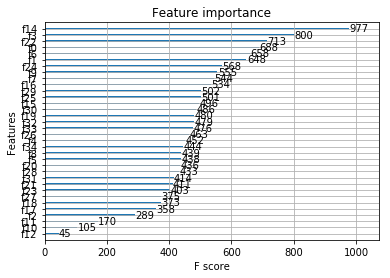

In [6]:
from xgboost import plot_importance

plot_importance(model)

In [9]:
for i, col in enumerate(X.columns):
    print(f'{i} : {col}')

0 : len_q1
1 : len_q2
2 : diff_len
3 : common_words
4 : len_char_q1
5 : len_char_q2
6 : ratio
7 : partial_ratio
8 : token_sort_ratio
9 : token_set_ratio
10 : qratio
11 : wratio
12 : partial_token_sort_ratio
13 : partial_token_set_ratio
14 : word_similarity
15 : 0
16 : 1
17 : 2
18 : 3
19 : 4
20 : 5
21 : 6
22 : 7
23 : 8
24 : 9
25 : 10
26 : 11
27 : 12
28 : 13
29 : 14
30 : 15
31 : 16
32 : 17
33 : 18
34 : 19
